# MDP using SNR-Based MCS Selection </br>
From CQI PREDICTION THROUGH RECURRENT NEURAL NETWORK FOR UAV CONTROL INFORMATION

## Imports

In [1]:
import tensorflow as tf
import pandas as pd # for data manipulation 
import numpy as np
import math, os
from scipy import special
from tqdm import tqdm

def euclidean_dist(row):
    # Function to calc euclidean distance on every df row 
    euc_dist = math.sqrt(row["U2G_Distance"]**2 - row["Height"]**2)
    return euc_dist

def q_func(x):
    q = 0.5 - 0.5*special.erf(x / np.sqrt(2))
    return q

def q_func_inv(x):
    q = math.sqrt(2) * special.erfinv(1-2*x)
    return q

def friis_calc(P,freq,dist,ple):
    '''
    Friis path loss equation
    P = Tx transmit power
    freq = Signal frequency
    dist = Transmission distance
    ple = Path loss exponent
    '''
    propagation_speed = 299792458
    l = propagation_speed / freq
    h_pl = P * l**2 / (16*math.pi**2)
    P_Rx = h_pl * dist**(-ple)
    return P_Rx

def plos_calc(h_dist, height_tx, height_rx, env='suburban'):
    '''
    % This function implements the LoS probability model from the paper
    % "Blockage Modeling for Inter-layer UAVs Communications in Urban
    % Environments" 
    % param h_dist    : horizontal distance between Tx and Rx (m)
    % param height_tx : height of Tx
    % param height_rx : height of Rx
    '''
    if env == 'suburban':
        a1 = 0.1
        a2 = 7.5e-4
        a3 = 8
    elif env == 'urban':
        a1 = 0.3
        a2 = 5e-4
        a3 = 15
    
    delta_h = height_tx - height_rx
    # pow_factor = 2 * h_dist * math.sqrt(a1*a2/math.pi) + a1 # NOTE: Use this pow_factor if assuming PPP building dist.
    pow_factor = h_dist * math.sqrt(a1*a2) # NOTE: Use this pow_factor if assuming ITU-R assumptions.
    if delta_h == 0:
        p = (1 - math.exp((-(height_tx)**2) / (2*a3**2))) ** pow_factor
    else:
        if delta_h < 0:
            h1 = height_rx
            h2 = height_tx
        else:
            h1 = height_tx
            h2 = height_rx
        delta_h = abs(delta_h)
        p = (1 - (math.sqrt(2*math.pi)*a3 / delta_h) * abs(q_func(h1/a3) - q_func(h2/a3))) ** pow_factor
    return p

def sinr_lognormal_approx(h_dist, height, env='suburban'):
    '''
    To approximate the SNR from signal considering multipath fading and shadowing
    Assuming no interference due to CSMA, and fixed noise
    Inputs:
    h_dist = Horizontal Distance between Tx and Rx
    height = Height difference between Tx and Rx
    env = The operating environment (currently only suburban supported)
    '''
    # Signal properties
    P_Tx_dBm = 20 # Transmit power of 
    P_Tx = 10**(P_Tx_dBm/10) / 1000
    freq = 2.4e9 # Channel frequency (Hz)
    noise_dBm = -86
    noise = 10**(noise_dBm/10) / 1000
    if env == "suburban":
        # ENV Parameters Constants ----------------------------------
        # n_min = 2
        # n_max = 2.75
        # K_dB_min = 7.8
        # K_dB_max = 17.5
        # K_min = 10**(K_dB_min/10)
        # K_max = 10**(K_dB_max/10)
        # alpha = 11.25 # Env parameters for logarithm std dev of shadowing 
        # beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        n_min = 2
        n_max = 2.75
        K_dB_min = 1.4922
        K_dB_max = 12.2272
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 11.1852 # Env parameters for logarithm std dev of shadowing 
        beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        # -----------------------------------------------------------
    elif env == "urban":
        n_min = 1.9
        n_max = 2.7
        K_dB_min = -5
        K_dB_max = 15
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 10.42 # Env parameters for logarithm std dev of shadowing 
        beta = 0.05 # Env parameters for logarithm std dev of shadowing 
    # Calculate fading parameters
    PLoS = plos_calc(h_dist, 0, height, env=env)
    theta_Rx = math.atan2(height, h_dist) * 180 / math.pi # Elevation angle in degrees
    ple = (n_min - n_max) * PLoS + n_max # Path loss exponent
    sigma_phi_dB = alpha*math.exp(-beta*theta_Rx)
    sigma_phi = 10**(sigma_phi_dB/10) # Logarithmic std dev of shadowing
    K = K_min * math.exp(math.log(K_max/K_min) * PLoS**2)
    omega = 1 # Omega of NCS (Rician)
    dist = math.sqrt(h_dist**2 + height**2)
    P_Rx = friis_calc(P_Tx, freq, dist, ple)
    # Approximate L-NCS RV (which is the SNR) as lognormal
    eta = math.log(10) / 10
    mu_phi = 10*math.log10(P_Rx)
    E_phi = math.exp(eta*mu_phi + eta**2*sigma_phi**2/2) # Mean of shadowing RV
    var_phi = math.exp(2*eta*mu_phi+eta**2*sigma_phi**2)*(math.exp(eta**2*sigma_phi**2)-1) # Variance of shadowing RV
    E_chi = (special.gamma(1+1)/(1+K))*special.hyp1f1(-1,1,-K)*omega
    var_chi = (special.gamma(1+2)/(1+K)**2)*special.hyp1f1(-2,1,-K)*omega**2 - E_chi**2
    E_SNR = E_phi * E_chi / noise # Theoretical mean of SINR
    var_SNR = ((var_phi+E_phi**2)*(var_chi+E_chi**2) - E_phi**2 * E_chi**2) / noise**2
    std_dev_SNR = math.sqrt(var_SNR)
    # sigma_ln = math.sqrt(math.log(var_SNR/E_SNR**2 + 1))
    # mu_ln = math.log(E_SNR) - sigma_ln**2/2
    return E_SNR, std_dev_SNR

def normalize_data(df, columns=[], save_details_path=None):
    '''
    columns: The pandas data columns to normalize, given as a list of column names
    '''
    # Define the ranges of parametrers
    max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
    max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
    min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
    min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
    max_height = 300
    min_height = 60
    max_h_dist = 1200
    min_h_dist = 0

    # Normalize data (Min Max Normalization between [-1,1])
    if "Height" in columns:
        df["Height"] = df["Height"].apply(lambda x: 2*(x-min_height)/(max_height-min_height) - 1)
    if "U2G_H_Dist" in columns:
        df["U2G_H_Dist"] = df["U2G_H_Dist"].apply(lambda x: 2*(x-min_h_dist)/(max_h_dist-min_h_dist) - 1)
    if "Mean_SINR" in columns:
        df["Mean_SINR"] = df["Mean_SINR"].apply(lambda x: 2*(10*math.log10(x)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1) # Convert to dB space
    if "Std_Dev_SINR" in columns:
        df["Std_Dev_SINR"] = df["Std_Dev_SINR"].apply(lambda x: 2*(10*math.log10(x)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1) # Convert to dB space
    if "UAV_Sending_Interval" in columns:
        df["UAV_Sending_Interval"] = df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 66.7: 0.5, 100:1, 1000:2})
    if "Packet_State" in columns:
        df['Packet_State'] = df['Packet_State'].replace({"Reliable":0, "QUEUE_OVERFLOW":1, "RETRY_LIMIT_REACHED":2, "Delay_Exceeded":3})
    if "Modulation" in columns:
        df['Modulation'] = df['Modulation'].replace({"BPSK":1, "QPSK":0.3333, 16:-0.3333, "QAM-16":-0.3333, "QAM16":-0.3333, 64:-1, "QAM-64":-1, "QAM64":-1})

    # Record details of inputs and output for model
    if save_details_path is not None:
        f = open(os.path.join(save_details_path,"model_details.txt"), "w")
        f.write("Max Height (m): {}\n".format(max_height))
        f.write("Min Height (m): {}\n".format(min_height))
        f.write("Max H_Dist (m): {}\n".format(max_h_dist))
        f.write("Min H_Dist (m): {}\n".format(min_h_dist))
        f.write("Max Mean SINR (dB): {}\n".format(max_mean_sinr))
        f.write("Min Mean SINR (dB): {}\n".format(min_mean_sinr))
        f.write("Max Std Dev SINR (dB): {}\n".format(max_std_dev_sinr))
        f.write("Min Std Dev SINR (dB): {}\n".format(min_std_dev_sinr))
        f.write("[BPSK: 1, QPSK: 0.3333, QAM16: -0.3333, QAM64: -1]\n")
        f.write("UAV Sending Interval: [10:-1, 20:-0.5, 40:0, 100:0.5, 1000:1]\n")
        f.write("Output: ['Reliable':0, 'QUEUE_OVERFLOW':1, 'RETRY_LIMIT_REACHED':2, 'Delay_Exceeded':3]\n")
        f.close()

    return df

def norm_MCS(mcs_index):
    return 2*mcs_index/7 - 1

# def achievable_rate(snr, err, blocklength):
#     C = math.log2(1 + snr)
#     V = 1 - (1 + snr)**(-2)
#     r = C - math.log2(math.e) * math.sqrt(V/blocklength) * q_func_inv(err)
#     return r

def achievable_rate(snr, err, blocklength, bandwidth):
    C = math.log(1 + snr)
    V = 1 - (1 + snr)**(-2)
    r = C - math.sqrt(V/blocklength) * q_func_inv(err)
    return bandwidth * r / math.log(2)

def snr_choose_mcs(snr, err, packet_size, bandwidth, mcs_datarate_list = None, code_rate_list = None):
    '''
    Based on CQI PREDICTION THROUGH RECURRENT NEURAL NETWORK FOR UAV CONTROL INFORMATION
    snr is in linear scale
    err is the decoding error probability required (compliment of reliability)
    packet_size is frame size in bytes (inclusive of headers)
    mcs_index_list: Optional mcs list to consider (sorted from highest datarate to lowest), else default datarates in IEEE 802.11n MCS will be used
    code_rate_list: Optional coding rate list corresponding to MCS in mcs_list
    '''
    if mcs_datarate_list == None:
        mcs_datarate_list = [65000000, 58500000, 52000000, 39000000, 26000000, 19500000, 13000000, 6500000]
    if code_rate_list == None:
        code_rate_list = [1/2, 1/2, 3/4, 1/2, 3/4, 2/3, 3/4, 5/6]
    assert len(mcs_datarate_list) == len(code_rate_list), "MCS Data Rate list must be same length as Code Rate list!"
    
    mcs_list_index = 0
    stop = 0
    for code_rate in code_rate_list:
        if stop == 0:
            blocklength = packet_size * 8 * 1 / code_rate
            r = achievable_rate(snr, err, blocklength, bandwidth)
            if mcs_datarate_list[mcs_list_index] <= r:
                stop = 1
            else:
                mcs_list_index += 1
    if mcs_list_index >= len(code_rate_list):
        mcs_list_index = len(code_rate_list) - 1

    return len(code_rate_list) - 1 - mcs_list_index # The MCS Index is reversed, highest datarate is highest index



2023-10-31 10:48:50.326185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 10:48:50.435301: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 10:48:50.439952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-31 10:48:50.439966: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

## Load Reliability Models

In [2]:
dl_model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_DJISpark/nn_checkpoints/djispark_nnv4_wobn_dl/model.010-0.2039.h5", compile=False)
dl_model.compile(optimizer='adam', 
              loss={'packet_state': 'categorical_crossentropy'},
              metrics={'packet_state': 'accuracy'})

ul_model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_DJISpark/nn_checkpoints/djispark_nnv4_wobn_ul/model.010-0.1202.h5", compile=False)
ul_model.compile(optimizer='adam', 
              loss={'packet_state': 'categorical_crossentropy'},
              metrics={'packet_state': 'accuracy'})

vid_model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/Dataset_NP10000_DJISpark/nn_checkpoints/djispark_nnv4_wobn_vid/model.010-0.2581.h5", compile=False)
vid_model.compile(optimizer='adam', 
              loss={'packet_state': 'categorical_crossentropy'},
              metrics={'packet_state': 'accuracy'})

2023-10-30 23:16:41.876287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-30 23:16:41.876394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-10-30 23:16:41.876470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-10-30 23:16:41.876542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-10-30 23:16:41.876614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

## SNR Based MCS Scheme

In [33]:
# SCENARIO: UAV swarm moving forward at fixed height

reliability_th = 0.99 # Target reliability 

horizontal_dist = np.linspace(0, 1200, 121, endpoint=True)

# Constants
height = 120 # In m
uav_send_int = 10 # In ms
packet_size = 1513 # In bytes
bandwidth = 20e6 # 20 MHz

max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
uav_send_int_norm = {10:-1, 20:-0.5, 40:0, 66.7: 0.5, 100:1, 1000:2}

state_record = []
for i in tqdm(range(0, len(horizontal_dist))):
    mean_sinr, std_dev_sinr = sinr_lognormal_approx(horizontal_dist[i], height)
    # m = np.max([mean_sinr - 3*std_dev_sinr, 0])
    mcs = snr_choose_mcs(m, 1-reliability_th, packet_size, bandwidth)
    norm_mean_sinr = 2*(10*math.log10(mean_sinr)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1
    norm_std_dev_sinr = 2*(10*math.log10(std_dev_sinr)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1
    next_dl_rel = dl_model.predict([[norm_mean_sinr, norm_std_dev_sinr, uav_send_int_norm[uav_send_int], norm_MCS(mcs)]], verbose=0)[0][0]
    next_ul_rel = ul_model.predict([[norm_mean_sinr, norm_std_dev_sinr, uav_send_int_norm[uav_send_int], norm_MCS(mcs)]], verbose=0)[0][0]
    next_vid_rel = vid_model.predict([[norm_mean_sinr, norm_std_dev_sinr, uav_send_int_norm[uav_send_int], norm_MCS(mcs)]], verbose=0)[0][0]
    state_record.append({"Horizontal_Distance": horizontal_dist[i], "Height": height, "UAV_Send_Interval": uav_send_int, "MCS": mcs, 
                        "DL_Reliability": next_dl_rel, "UL_Reliability": next_ul_rel, "Vid_Reliability": next_vid_rel})
snr_actions = pd.DataFrame(state_record)
snr_actions.to_csv("mdp_policy/test_snr_based_MCS_height_{}m_usi_{}.csv".format(height, uav_send_int))

100%|██████████| 121/121 [00:25<00:00,  4.81it/s]


Text(0.5, 1.0, 'Mean SNR vs Horizontal Distance')

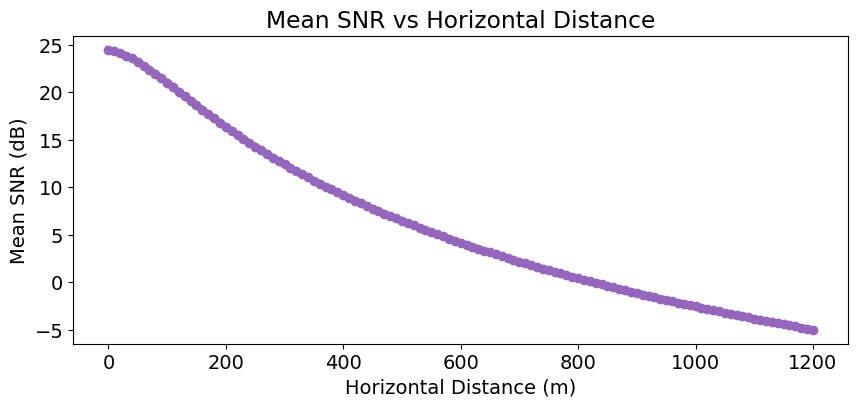

In [3]:
import matplotlib.pyplot as plt

# Calc mean SINR vs h_dist
horizontal_dist = np.linspace(0, 1200, 121, endpoint=True)
height = 120
mean_sinr = []

for h_dist in horizontal_dist:
    m, s = sinr_lognormal_approx(h_dist, height)
    mean_sinr.append(10*math.log10(m))

plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
plt.plot(horizontal_dist, mean_sinr, '-o', c="tab:purple", linewidth=5)
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Mean SNR (dB)")
plt.title("Mean SNR vs Horizontal Distance")